# Bus Stops in Buenos Aires (CABA) - EDA


## 1. Introduction

In this notebook I explore the distribution of bus stops in Buenos Aires (CABA). I use the cleaned layers from the data cleaning step (stops, streets, comunas, barrios) to get a basic overview, compare areas, and spot patterns on maps.

The goal here is not to build a model, but to understand where stops are concentrated, how coverage looks across the city, and which streets/lines stand out.

### 1.2 Questions/Objectives:

- How many stops are there in total, and how are they distributed across communes and neighborhoods?
- Which areas concentrate the highest number of stops?
- Which comunas and barrios have the highest stop density (stops per km²)?
- Which streets have the most stops? Do they look like main corridors?
- Which bus lines have the most stops, and which comunas/barrios have the most distinct lines?
- Where are the highest-connectivity stop areas in the city (based on distinct bus lines)?

## 1. Introduction
### 1.1 Context
### 1.2 Questions

## 2. Setup
### 2.1 Imports
### 2.2 Loading processed data
### 2.3 Plot settings

## 3. Overview
### 3.1 Quick look (rows, columns, basic checks)
### 3.2 Stops by comuna
### 3.3 Stops by barrio
### 3.4 Map of stops
### 3.5 Density map (heatmap / hexbin)

## 4. Stops per km²
### 4.1 Areas (km²) by comuna and barrio
### 4.2 Density ranking (top/bottom)
### 4.3 Density maps

## 5. Streets with most stops
### 5.1 Stops per street (top N)
### 5.2 Map of top streets / corridors (optional)

## 6. Lines & coverage
### 6.1 Lines with most stops
### 6.2 Comunas/barrios with most distinct lines
### 6.3 (Optional) Stop areas served by most lines (clusters)


## 2. Setup:

### Imports

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from shapely.geometry import Point
from pathlib import Path

### Initial settings

In [4]:
%matplotlib inline
sys.path.append(str(Path.cwd().parent / "src"))
PROJECT_ROOT = Path.cwd().parent
PROCESSED_PATH = PROJECT_ROOT / "data" / "processed"

### Loading processed Data:

In [10]:
stops = gpd.read_file(PROCESSED_PATH / "stops.gpkg")
streets = gpd.read_file(PROCESSED_PATH / "calles.gpkg")
comunas = gpd.read_file(PROCESSED_PATH / "comunas.gpkg")
barrios = gpd.read_file(PROCESSED_PATH / "barrios.gpkg")

## 3. Overview

### 3.1 Quick look

Before jumping into plots, I will do a quick check of shapes, CRS, geometry types and a few key values. This helps catch obvious issues early (missing values, wrong CRS, out-of-range codes).


In [ ]:
aux_mapp = {"stops": stops, "streets": streets, "comunas": comunas, "barrios": barrios}
# Shapes
print("Shapes")
for name, gdf in aux_mapp.items():
    print(f"{name}: {gdf.shape}")


Shapes
stops: (6961, 12)
streets: (2742, 4)
comunas: (15, 5)
barrios: (48, 5)


In [19]:
# CRS
print("CRS")
for name, gdf in aux_mapp.items():
    print(f"{name}: {gdf.crs}")

CRS
stops: EPSG:4326
streets: EPSG:4326
comunas: EPSG:4326
barrios: EPSG:4326


In [20]:
# Geometry types
print("Geometry types")
for name, gdf in {"stops": stops, "streets": streets, "comunas": comunas, "barrios": barrios}.items():
    print(f"\n{name}")
    print(gdf.geometry.geom_type.value_counts())

Geometry types

stops
Point    6961
Name: count, dtype: int64

streets
MultiLineString    2742
Name: count, dtype: int64

comunas
MultiPolygon    15
Name: count, dtype: int64

barrios
Polygon    48
Name: count, dtype: int64


In [21]:
# Bounds (sanity check)
print("Bounds (total_bounds)")
for name, gdf in {"stops": stops, "streets": streets, "comunas": comunas, "barrios": barrios}.items():
    print(f"{name}: {gdf.total_bounds}")

Bounds (total_bounds)
stops: [-58.5304892 -34.7006587 -58.34234   -34.53648  ]
streets: [-58.5324417  -34.70574495 -58.34190732 -34.52947415]
comunas: [-58.53151731 -34.70535548 -58.33515706 -34.52649644]
barrios: [-58.53151731 -34.70535548 -58.33515706 -34.52649644]


In [24]:
# Missing values (key fields)
key_cols = ["calle", "direccion", "barrio", "comuna", "n_lines", "geometry"]
print("Percentage of missing values in stops")
display(stops[key_cols].isna().mean().mul(100).sort_values(ascending=False))

Percentage of missing values in stops


barrio       0.014366
calle        0.000000
direccion    0.000000
comuna       0.000000
n_lines      0.000000
geometry     0.000000
dtype: float64

In [27]:
# Basic counts / ranges
print("Basic checks")
print("Total stops:", len(stops))
print("Distinct comunas (stops):", stops["comuna"].nunique())
print("Distinct barrios (stops):", stops["barrio"].nunique())

Basic checks
Total stops: 6961
Distinct comunas (stops): 15
Distinct barrios (stops): 48


#### Quick conclusions
All DataFrames share the same CRS (EPSG:4326) and geometry types match what I expect (stops as points, streets as multilines, comunas and barrios as multipolygons/polygons). The stops dataset is basically complete: all key fields are non-missing, and `barrio` has only a negligible amount of missing values, around 0.01%.

I expected coordinates to fall roughly within CABA (around lon -59 to -58 and lat -35 to -34), and the bounds match this range, so there are no obvious outliers far away from the city.

The dataset also matches the official reference counts (15 comunas and 48 barrios).

### 3.2 Stops by commune

Here I count how many stops fall in each comuna. This gives me a first overview of where stops are more concentrated.

In [57]:
stops_by_comuna = stops.groupby("comuna").size().sort_values(ascending=False).rename("n_stops").reset_index()
stops_by_comuna

,comuna,n_stops
0,1,939
1,4,752
2,15,531
3,14,489
4,9,478
5,12,476
6,3,438
7,8,405
8,7,401
9,11,390


A simple bar plot makes it easier to compare comunas and quickly spot the highest and lowest values.

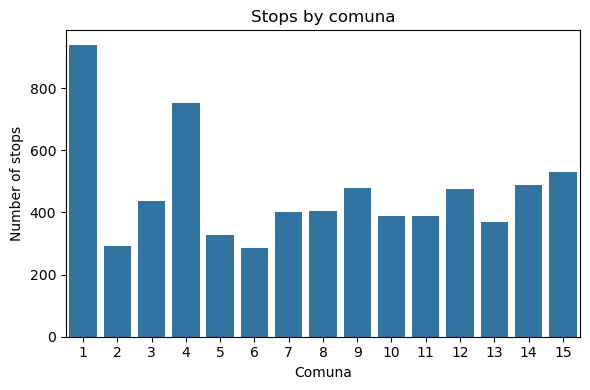

In [60]:
plt.figure(figsize=(6, 4))
sns.barplot(data=stops_by_comuna,y="n_stops",x="comuna",color="C0")
plt.title("Stops by comuna")
plt.ylabel("Number of stops")
plt.xlabel("Comuna")
plt.tight_layout()

Finally, I map the counts to see the spatial pattern and confirm it matches what I expect visually.

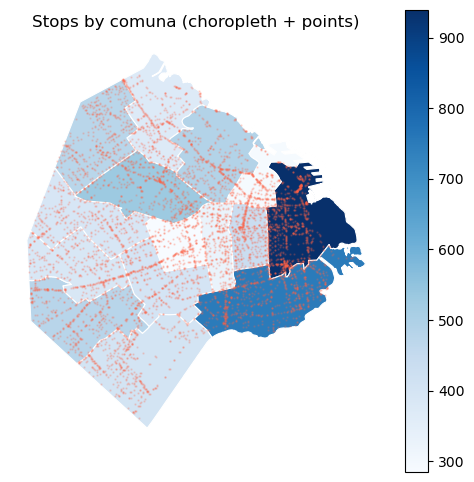

In [83]:
comunas_counts = comunas.merge(stops_by_comuna, on="comuna", how="left")
fig, ax = plt.subplots(figsize=(6,6))

comunas_counts.plot(ax=ax, column="n_stops", cmap="Blues", figsize=(6, 6), edgecolor="white", linewidth=0.8, legend=True)
stops.plot(ax=ax, markersize=0.5, color="tomato", alpha=0.2)
ax.set_title("Stops by comuna (choropleth + points)")
ax.set_axis_off()

Comuna 1 has the highest number of stops in this dataset. This is expected, since it covers a central area with high activity and many transit connections.

On the other hand, the comunas with the lowest stop counts may reflect lower stop density and/or more spread-out land use. I will confirm this later by looking at stops per km² (because raw counts can be misleading if the area is larger).

To add some context, I list the barrios included in the highest and lowest comunas (based on the official comunas layer).

In [87]:
# Which barrios are included in the highest/lowest comunas?
top_comuna = int(stops_by_comuna.iloc[0]["comuna"])
bottom_comuna = int(stops_by_comuna.iloc[-1]["comuna"])

print("Top comuna:", top_comuna)
display(comunas.loc[comunas["comuna"] == top_comuna, ["comuna", "barrios"]])

print("Bottom comuna:", bottom_comuna)
display(comunas.loc[comunas["comuna"] == bottom_comuna, ["comuna", "barrios"]])


Top comuna: 1


,comuna,barrios
0,1,CONSTITUCION SAN TELMO MONSERRAT RETIRO PUERTO...


Bottom comuna: 6


,comuna,barrios
5,6,CABALLITO
